In [112]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB, CategoricalNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier

***Get Data***

In [166]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, CD4_Attributes, CD4_ClassResults = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VL_Attributes, VL_ClassResults = pickle.load(f)
with open('../DataBases/CD4EncodedBaseBalanced.pkl', 'rb') as f:
    columns, CD4_AttributesBalanced, CD4_ClassResultsBalanced = pickle.load(f)
with open('../Databases/VlEncodedBaseBalanced.pkl', 'rb') as f:
    columns, VL_AttributesBalanced, VL_ClassResultsBalanced = pickle.load(f)

***Generate training and test***

In [167]:
Cd4AttributesTraining, Cd4AttributesTest, Cd4ClassResultsTraining, Cd4ClassResultsTest = train_test_split(CD4_Attributes, CD4_ClassResults, test_size=0.2, random_state=0)
VlAttributesTraining, Vl4AttributesTest, VlClassResultsTraining, VlClassResultsTest = train_test_split(VL_Attributes, VL_ClassResults, test_size=0.2, random_state=0)
Cd4AttributesTrainingBalanced, Cd4AttributesTestBalanced, Cd4ClassResultsTrainingBalanced, Cd4ClassResultsTestBalanced = train_test_split(CD4_AttributesBalanced, CD4_ClassResultsBalanced, test_size=0.2, random_state=0)
VlAttributesTrainingBalanced, VlAttributesTestBalanced, VlClassResultsTrainingBalanced, VlClassResultsTestBalanced = train_test_split(VL_AttributesBalanced, VL_ClassResultsBalanced, test_size=0.2, random_state=0)

***GridSearch***

In [168]:
param_grid = [
    {
        'estimator': [OneVsRestClassifier(MultinomialNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False]
    },
    {
        'estimator': [OneVsRestClassifier(BernoulliNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False],
        'estimator__estimator__binarize': np.linspace(0.1, 0.9, 9)
    },
    {
        'estimator': [OneVsRestClassifier(GaussianNB())],
        'estimator__estimator__var_smoothing': np.logspace(-9,-6 ,4)
    },
    {
        'estimator': [OneVsRestClassifier(ComplementNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3 ,7),
        'estimator__estimator__fit_prior': [True,False],
        'estimator__estimator__norm':[True,False]
    },
    {
        'estimator': [OneVsRestClassifier(CategoricalNB())],
        'estimator__estimator__alpha': np.logspace(-3 ,3 ,7),
    }
]

In [169]:
grid_search = GridSearchCV(estimator=OneVsRestClassifier(DummyClassifier()), param_grid=param_grid, cv=5, scoring='accuracy')

In [170]:
grid_search.fit(VL_AttributesBalanced, VL_ClassResultsBalanced)

c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py", line 98, in _predict_binary
    score = np.ravel(estimator.decision_function(X))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_available_if.py", line 33, in __get__
    raise attr_err
AttributeError: This 'OneVsRestClassifier' has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = s

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=DummyClassifier()),
             param_grid=[{'estimator': [OneVsRestClassifier(estimator=MultinomialNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=BernoulliNB())],
                          'es...
                         {'estimator': [OneVsRestClassifier(estimator=ComplementNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False],
                          'estimator__estimator__norm': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=CategoricalNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}],
             scoring='accuracy')

In [171]:
print("Best hyperparameter:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Best hyperparameter: {'estimator': OneVsRestClassifier(estimator=GaussianNB()), 'estimator__estimator__var_smoothing': 1e-09}
Accuracy: 0.6545183534945969


c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


0.6421499292786421

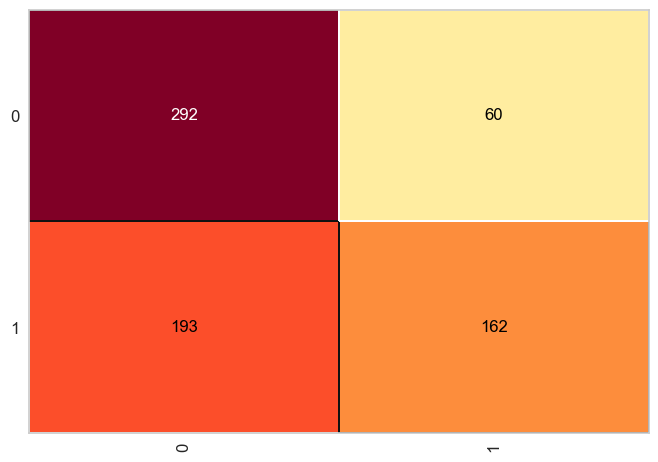

In [172]:
model = OneVsRestClassifier(estimator=GaussianNB(var_smoothing=1e-09))
model_final = model.fit(VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced)

cm = ConfusionMatrix(model_final)
cm.score(VlAttributesTestBalanced, VlClassResultsTestBalanced)

In [174]:
# Make predictions on test set
y_pred = model_final.predict(VlAttributesTestBalanced)

# Generate classification report
report = classification_report(VlClassResultsTestBalanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       352
           1       0.73      0.46      0.56       355

    accuracy                           0.64       707
   macro avg       0.67      0.64      0.63       707
weighted avg       0.67      0.64      0.63       707

